In [1]:
# Import all the things

%matplotlib inline
import math

from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sqlalchemy import create_engine
plt.style.use('seaborn-darkgrid')
import pyproj
import turfpy
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, MultiPolygon, Feature, FeatureCollection
from statsmodels.graphics.gofplots import qqplot_2samples, qqplot

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression,  mutual_info_regression, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pyproj import Proj
from pyproj import CRS, Transformer

# For displaying LaTeX when outputting 
from IPython.display import display, Markdown


# DIT-862 project 2021

# Problem definition and motivation

This is an investigation into factors affecting the housing market in Gothenburg and Mölndal municipalities, based on data collected in Q4 2021. In particular, the presence or absence of several features will be confirmed as to their significance in determination of an apartment's value, such as the floor of an apartment is on in a building, or the monthly fee to the tenancy association.  Those buying an apartment for the first time in Sweden are operating in an environment with limited data and have to rely on intuition concerning the actual value, as much historical data concerning apartments is no longer available once a purchase is completed.  The project definition may be therefore be stated as being:

*This project uses a dataset of historical apartment purchases from hemnet.se to assist first time buyers with limited information predict the true value of a property in Gothenburg and Mölndal municipalities based on different characteristics of the property*

# Data specification

The data were retrieved from the website https://hemnet.se, which is a popular website advertising property in Sweden.  Unfortunately there is no API, so it was necessary to use page scraping.  Prior to commencing this, robots.txt was checked, and there were no restrictions - only a suggestion to send them a speculative job application.  The content of the robots file is below:

    # Kul att du hittat hit!
    # Vill du också jobba på en av Sveriges största sajter med miljontals unika besökare?
    # Gör en spontanansökan på https://career.hemnet.se/

    User-agent: *

    Sitemap: https://www.hemnet.se/sitemap.xml

However, out of courtesy a gap of 5 seconds was maintained between each request, and the application was implemented with only a single thread so as to minimise load.

The data was restricted to apartments (bostadsrätt) in Gothenburg and Mölndal municipalities. It would be possible to obtain additional data by querying each part of the city separately (so the maximum of 50 pages of results would have fewer properties and go back further before exhausting the results).  However, this was deemed unnecessary, and it would additionally complicate analysis as the values of properties change over time.  Within Q4 2021 there was no real change, so no compensation was required for the figures.

Given the range of house prices, these data were supplemented with additional data from the Swedish election authority which has the country divided into quite granular areas from the 2018 Swedish general election.  The data may be found https://data.val.se/val/val2018/statistik/2018_valgeografi_valdistrikt.zip.

These data were converted from GIS format to GeoJSON using an open source tool, and the voting region for each property was determined.  We can expect that the average prices for each voting area will vary considerably across the city.

# Data preparation and setup

## Data preparation 

The interested reader can use the file `Data preparation.ipynb` for the process of aggregating the two datasets, and loading into a CSV file.  This notebook continues assuming that the previous notebook has already been run.

## Data setup

The following table provides an overview of the uncleaned data.

In [2]:
data = pd.read_csv('data/data.csv')
data.head()

,id,address,sale_date,asked_price,sold_price,rooms,living_space,has_balcony,floor,avgift,driftskostnad,built,total_floors,has_lift,lat,lng,avgift_sqm,valdistrikt
0,563,Eklanda Hage 145C,2020-12-30,4350000.0,4510000,5.0,116.0,NaN,NaN,6296.0,15456.0,1997-01-01,NaN,0,57.654146,11.963737,54.275862,Eklanda Västra
1,564,Högenvägen 23,2020-12-30,2595000.0,2800000,3.0,72.0,1.0,2.0,3735.0,7140.0,2100-01-01,2.0,0,57.607780,12.058046,51.875000,Brattås Södra
2,565,Frälsegårdsgatan 1 B,2020-12-29,1150000.0,2300000,2.0,54.0,NaN,2.0,2539.0,4980.0,1957-01-01,3.0,0,57.660761,12.001016,47.018519,Bosgården Södra
3,566,Toltorpsgatan 50 B,2020-12-29,900000.0,2000000,1.0,34.0,NaN,NaN,1781.0,NaN,2100-01-01,NaN,0,57.673123,11.978522,52.382353,Toltorp Norra
4,567,Broslättsgatan 36 lgh 1203,2020-12-23,3150000.0,3150000,2.0,54.0,1.0,2.0,3506.0,NaN,2100-01-01,2.0,1,57.654087,12.011442,64.925926,Broslätt Västra


### Missing data

Not all data are present for all properties, so some effort was necessary to clean the dataset.  There were a total of 3104 rows, though as even the summary shows, and the count below, several rows contain fields which are either invalid or missing.  As the dataset is still quite large, missing rows will simply be dropped, though future work could seek to create improved fallbacks.

In [3]:
data.count()

id               3104
address          3104
sale_date        3104
asked_price      2865
sold_price       3104
rooms            3102
living_space     3103
has_balcony      1857
floor            2558
avgift           3103
driftskostnad    2583
built            3104
total_floors     2278
has_lift         3104
lat              3104
lng              3104
avgift_sqm       3102
valdistrikt      3104
dtype: int64

In [4]:
data = data[data.rooms.notnull()]
data = data[data.avgift.notnull()]
data.dropna(subset=['rooms', 'avgift', 'avgift_sqm', 'floor', 'driftskostnad'], inplace=True)
data.count()

id               2092
address          2092
sale_date        2092
asked_price      1939
sold_price       2092
rooms            2092
living_space     2092
has_balcony      1447
floor            2092
avgift           2092
driftskostnad    2092
built            2092
total_floors     1776
has_lift         2092
lat              2092
lng              2092
avgift_sqm       2092
valdistrikt      2092
dtype: int64

### Cleaning invalid data



Some properties do not specify whether there is a lift in the building, or a balcony in that property.  As these are positive features for an apartment or building, it was assumed that if they are not specified the property does not have them.  As such, these defaulted to `False`.

In [5]:
data['has_balcony'] = data['has_balcony'].fillna(False)
data['has_lift'] = data['has_lift'].fillna(False)
data.count()

id               2092
address          2092
sale_date        2092
asked_price      1939
sold_price       2092
rooms            2092
living_space     2092
has_balcony      2092
floor            2092
avgift           2092
driftskostnad    2092
built            2092
total_floors     1776
has_lift         2092
lat              2092
lng              2092
avgift_sqm       2092
valdistrikt      2092
dtype: int64

There were 19 rows of the built date which had the year 2100 to signify that the year was not specified.  These fields were also strings, so we convert them to datetime, and remove them.  When considering the overall aim of the tool, of advising people with limited information about an apartment, the year it was built is a key piece of information which should be held, so we assume that anyone buying an apartment will have this information or be able to ask for it.

In [6]:
data['built'] = pd.to_datetime(data['built'])
data['built'] = data['built'].dt.year
data = data.loc[data['built'] < 2100]
# In some iterations of the data collection, unknown floors were set as -1 since no real floor would have that
data = data.loc[data['floor'] > -1]

### Cost per square metre

The `avgift_sqm` was already calculated, but it was also necessary to calculate other costs per square metre to get a more objective idea of values.

For example, intuitively one would suspect that there is a necessary lower bound for getting an apartment building set up, after which the increased size would become less expensive for each additional square metre.  Therefore, the field `sold_price_sqm` was added.

Similarly, the operating cost (`driftskostnad`) is an estimate of the amount of additional money which will need to be spent on the apartment aside from the items included in the monthly fee, for example electricity, home insurance, or parking.  If the monthly fee is a feature which affects the value of an apartment, the operating cost is likely to also be considered so - even though it is considerably smaller.  As such, an additional field of `cost_per_month` was added, which is the total of the monthly fee + annual operating costs.  In addition, the related field `cost_per_sqm` was added, so that the costs of an individual apartment could be seen regardless of the size.

In [7]:
data['sold_price_sqm'] = data['sold_price'] / data['living_space']
data['cost_per_month'] = data['avgift'] + (data['driftskostnad'] / 12)
data['cost_per_sqm'] = data['cost_per_month'] / data['living_space']
data.head()

,id,address,sale_date,asked_price,sold_price,rooms,living_space,has_balcony,floor,avgift,...,built,total_floors,has_lift,lat,lng,avgift_sqm,valdistrikt,sold_price_sqm,cost_per_month,cost_per_sqm
2,565,Frälsegårdsgatan 1 B,2020-12-29,1150000.0,2300000,2.0,54.0,False,2.0,2539.0,...,1957,3.0,0,57.660761,12.001016,47.018519,Bosgården Södra,42592.592593,2954.0,54.703704
6,569,Häradsgatan 31,2020-12-22,2350000.0,2560000,2.0,57.0,1.0,3.0,3501.0,...,1957,7.0,1,57.662186,12.004269,61.421053,Bosgården Södra,44912.280702,3861.0,67.736842
7,570,Pinnharvsgatan 7E,2020-12-21,1850000.0,1850000,2.0,53.0,False,1.0,3622.0,...,1968,3.0,0,57.661414,11.992174,68.339623,Västerberg,34905.660377,3927.0,74.094340
8,571,Tvillinggatan 7 A,2020-12-18,2200000.0,2620000,3.0,66.0,1.0,2.0,2836.0,...,1960,3.0,0,57.657920,11.997192,42.969697,Fässberg Västra,39696.969697,3361.0,50.924242
9,572,Utsädesgatan 4 B,2020-12-17,2100000.0,2560000,3.0,77.0,1.0,1.0,4544.0,...,1970,3.0,0,57.660423,11.993615,59.012987,Västerberg,33246.753247,5034.0,65.376623


### Scaling the sold price

Widely differing prices in Gothenburg/Mölndal depending on the desirability of the area may be a factor.  Given that we have the voting districts data available, we have the possibility to scale the sold price appropriately. A crude metric was used, where the mean of the dataset was taken, and the mean of each voting district was taken and the ratio was used as a scaling factor to standardise the price.

In [8]:
overall_mean = data['sold_price_sqm'].mean()

valdistrikt_mean = data.groupby('valdistrikt')['sold_price_sqm'].mean()
print(f'overall_mean {overall_mean}, valdistrikt_mean {valdistrikt_mean}')

overall_mean 52494.88671319485, valdistrikt_mean valdistrikt
Angered, Agnesberg                   22278.673835
Angered, Angereds Centrum            31875.000000
Angered, Bergum                      33586.879433
Angered, Björsared                   30357.142857
Angered, Eriksbo                     22049.214204
                                         ...     
Östra Göteborg, Kortedala, Västra    30456.838230
Östra Göteborg, Kortedala, Östra     37267.183602
Östra Göteborg, Kviberg, Östra       49952.785740
Östra Göteborg, Nylöse               46347.847358
Östra Göteborg, Utbynäs              24691.358025
Name: sold_price_sqm, Length: 270, dtype: float64


Even from the short summary above, one can see that the decision to scale the prices is somewhat justified.  An apartment in Kviberg Östra is 49952 SEK/$m^2$, whereas an apartment in Agnesberg in Angered has a mean of 22278 SEK/$m^2$ which is less than half.  Given the wide geographical area that Gothenburg and Mölndal municipalities encompases, alongside differing demographics and demands, it is inevitable that there will be a fairly wide range.  This is demonstrated more starkly by comparing the biggest and smallest mean, which has a range 73848 SEK/$m^2$.

In [9]:
max_valdistrikt = data.groupby('valdistrikt')['sold_price_sqm'].mean().max()
min_valdistrikt = data.groupby('valdistrikt')['sold_price_sqm'].mean().min()
print(f'{max_valdistrikt} - {min_valdistrikt} = {max_valdistrikt - min_valdistrikt}')

91549.2957746479 - 17700.609603184752 = 73848.68617146314


That said, this comes with the caveat that while it's considerably better for performance when calculating predictive models, it suffers from the same weaknesses in regards to its statistical validity.  There are 270 unique voting districts, which means that even if they were uniformly distributed there will be districts where n < 30 - often considered a sample size.

For the purposes of these data, however, this assumption was made: that each voting district has enough sold apartments to generate a statistically valid sample mean, and that the sample mean is representative of the population mean for that district.

In [10]:
scaled_price = []
for i, row in data.iterrows():
    v_mean = valdistrikt_mean[row["valdistrikt"]]
    scaled = row["sold_price"] * overall_mean / v_mean
    scaled_price.append(scaled)
data['scaled_price'] = np.array(scaled_price)
data['scaled_price_sqm'] = data['scaled_price'] / data['living_space']
data.head()

,id,address,sale_date,asked_price,sold_price,rooms,living_space,has_balcony,floor,avgift,...,has_lift,lat,lng,avgift_sqm,valdistrikt,sold_price_sqm,cost_per_month,cost_per_sqm,scaled_price,scaled_price_sqm
2,565,Frälsegårdsgatan 1 B,2020-12-29,1150000.0,2300000,2.0,54.0,False,2.0,2539.0,...,0,57.660761,12.001016,47.018519,Bosgården Södra,42592.592593,2954.0,54.703704,2.566014e+06,47518.778964
6,569,Häradsgatan 31,2020-12-22,2350000.0,2560000,2.0,57.0,1.0,3.0,3501.0,...,1,57.662186,12.004269,61.421053,Bosgården Södra,44912.280702,3861.0,67.736842,2.856085e+06,50106.758230
7,570,Pinnharvsgatan 7E,2020-12-21,1850000.0,1850000,2.0,53.0,False,1.0,3622.0,...,0,57.661414,11.992174,68.339623,Västerberg,34905.660377,3927.0,74.094340,2.742671e+06,51748.501942
8,571,Tvillinggatan 7 A,2020-12-18,2200000.0,2620000,3.0,66.0,1.0,2.0,2836.0,...,0,57.657920,11.997192,42.969697,Fässberg Västra,39696.969697,3361.0,50.924242,3.399699e+06,51510.590178
9,572,Utsädesgatan 4 B,2020-12-17,2100000.0,2560000,3.0,77.0,1.0,1.0,4544.0,...,0,57.660423,11.993615,59.012987,Västerberg,33246.753247,5034.0,65.376623,3.795263e+06,49289.131229


### Drop irrelevent features

Not all the fields will be required for the analysis, so they are being removed now to make future analysis simpler.

In [11]:
to_drop = ['id', 'address', 'sale_date', 'asked_price', 'total_floors', 'lat', 'lng', 'valdistrikt']

data = data.drop(columns=to_drop)
data

,sold_price,rooms,living_space,has_balcony,floor,avgift,driftskostnad,built,has_lift,avgift_sqm,sold_price_sqm,cost_per_month,cost_per_sqm,scaled_price,scaled_price_sqm
2,2300000,2.0,54.0,False,2.0,2539.0,4980.0,1957,0,47.018519,42592.592593,2954.00,54.703704,2.566014e+06,47518.778964
6,2560000,2.0,57.0,1.0,3.0,3501.0,4320.0,1957,1,61.421053,44912.280702,3861.00,67.736842,2.856085e+06,50106.758230
7,1850000,2.0,53.0,False,1.0,3622.0,3660.0,1968,0,68.339623,34905.660377,3927.00,74.094340,2.742671e+06,51748.501942
8,2620000,3.0,66.0,1.0,2.0,2836.0,6300.0,1960,0,42.969697,39696.969697,3361.00,50.924242,3.399699e+06,51510.590178
9,2560000,3.0,77.0,1.0,1.0,4544.0,5880.0,1970,0,59.012987,33246.753247,5034.00,65.376623,3.795263e+06,49289.131229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097,9000000,4.0,133.0,1.0,1.0,3293.0,6768.0,1929,1,24.759398,67669.172932,3857.00,29.000000,6.152932e+06,46262.644058
3099,2295000,3.0,81.0,1.0,2.0,5378.0,6900.0,1972,1,66.395062,28333.333333,5953.00,73.493827,3.229789e+06,39873.933550
3100,2050000,1.0,41.0,False,1.0,2606.0,5160.0,2016,1,63.560976,50000.000000,3036.00,74.048780,2.374524e+06,57915.222390
3101,4325000,3.0,79.0,1.0,4.0,5448.0,4200.0,2004,1,68.962025,54746.835443,5798.00,73.392405,4.499201e+06,56951.913467


## Descriptive analysis (4 pts)

* Show the histogram of some selected variables and describe what you conclude.
* Show the dependence of some selected variables and describe what you conclude.
* Describe the data using its range, sample mean, sample standard deviation and some quantiles.
* Choose a visualization method to explore the data set.
* **Explain how your analysis relates to the objective of your project**, i.e. why are these selected variables important? For example, for the diabetes data set, we choose to look at the “blood sugar level” and the “bmi body mass index” because they have the highest correlation with the target value y. Note: this is a dummy example. It is not necessarily true. You should motivate your conclusion with facts. 

This section will serve as an exploratory data analysis, and seek to confirm or refute some of the initial intuition behind the data.  Overall descriptive statistics of the data may be seen below:

In [12]:
data.describe()

,sold_price,rooms,living_space,floor,avgift,driftskostnad,built,has_lift,avgift_sqm,sold_price_sqm,cost_per_month,cost_per_sqm,scaled_price,scaled_price_sqm
count,1.920000e+03,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1.920000e+03,1920.000000
mean,3.298065e+06,2.378646,64.055208,2.913542,3783.363021,5297.308333,1968.328646,0.501042,60.539633,52494.886713,4224.805382,67.791674,3.308113e+06,52494.886713
std,1.486872e+06,0.896326,20.710292,2.043769,1110.550353,2460.806541,35.179860,0.500129,10.908799,16153.480615,1186.928452,11.708059,1.024155e+06,7076.030016
min,9.700000e+05,1.000000,17.000000,0.000000,623.000000,330.000000,1805.000000,0.000000,6.771739,13917.525773,1023.000000,11.119565,1.254002e+06,27049.438467
25%,2.325000e+06,2.000000,51.000000,2.000000,2980.000000,3900.000000,1945.000000,0.000000,54.000000,40350.877193,3377.625000,60.967778,2.557678e+06,47973.618060
50%,2.950000e+06,2.000000,62.000000,2.000000,3696.500000,4800.000000,1967.000000,1.000000,60.649958,52294.197031,4126.500000,67.717623,3.142046e+06,52334.674476
75%,3.900000e+06,3.000000,77.000000,4.000000,4485.750000,6018.000000,2008.000000,1.000000,67.404730,63469.169719,4963.437500,74.714878,3.867264e+06,56296.380051
max,1.665000e+07,6.000000,205.000000,16.000000,9136.000000,27312.000000,2022.000000,1.000000,102.705882,125757.575758,11412.000000,119.617647,9.945775e+06,100888.730945


We would expect the size of the apartment has a positive correlation to the overall value.  However, the degree to which other factors influence the output variable should also be investigated:

### Apartment size vs sold price

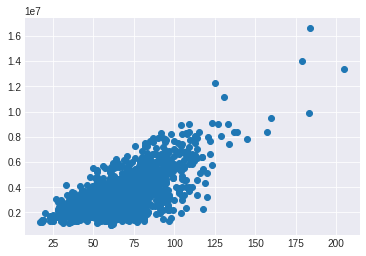

In [13]:
plt.scatter(data['living_space'], data['sold_price'])

### Amount of rooms vs scaled price

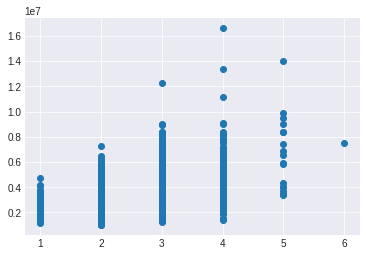

In [14]:
plt.scatter(data['rooms'], data['sold_price'])

<AxesSubplot:>

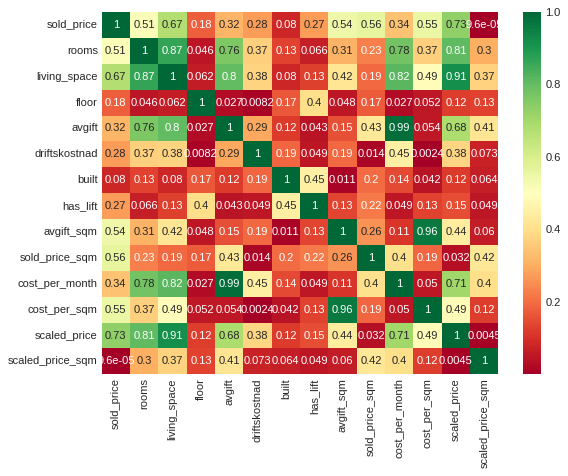

In [15]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

corr_map = data.corr().abs()
sns.heatmap(corr_map,annot=True,cmap="RdYlGn")

Most of these correlations are unsurprising.  The most strongly correlated is cost_per_month and avgift, but since cost_per_month includes the avgift almost entirely that is to be expected.  Similarly, cost/sqm and avgift/sqm so we will need to ensure that we use either the total cost or the avgift at any one time.

Some of the other fields also predict each other, notably avgift and rooms/living space.  This is also unsurprising, because the monthly fee is calculated by the housing association based on the size of the apartment, even if it is displayed as an absolute number.  This is the reason for the avgift/sqm field, which can be used as amore objective method of calculating the cost.

Finally, that rooms and living space are also highly correlated should not be a surprise.  A bigger apartment is intuitively very likely to have more rooms than a smaller apartment.

### Monthly fee/$m^2$ vs sold price

This final piece of descriptive analysis was somewhat of an indulgence.  The author lives in an apartment with a comparatively high monthly fee, and wished to see how much of an impact it would have on the overall price.  A higher fee does appear to have a small negative effect on the sold price, but there is so much noise it is impossible to conclude anything.

                sold_price_sqm  avgift_sqm
sold_price_sqm        1.000000   -0.258387
avgift_sqm           -0.258387    1.000000


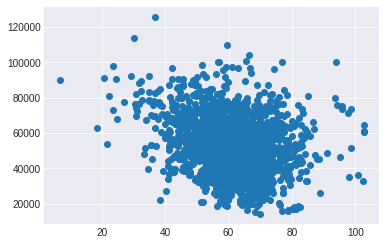

In [16]:
# Avgift/sqm vs scaled price/sqm

data_price_sqm = data['sold_price_sqm']
data_avgift_sqm = data['avgift_sqm']
print(data[['sold_price_sqm', 'avgift_sqm']].corr())

plt.show(plt.scatter(data_avgift_sqm, data_price_sqm))

## Probability distribution (5pts)

* Use probability distributions to describe some selected variables.
* What are the parameters in the distribution? Estimate these parameters.
* Use hypothesis testing to show some interesting conclusions.


### Sold price vs scaled price

It would be expected that there is a long tail of apartment values, so this is the first thing to check.  If the data are obviously not Gaussian then additional manipulation of the data may be required.  As discussed in the previous section, we also expect high variance across different regions.

In the previous section, the mean was taken from the sample of sold prices in order to generate the scaled prices.  Using the simplifying assumption that this is the true mean, the maximum likelihood function of both the sold price and sale price were calculated.

The histograms of both showed that it appeared to follow a Gaussian distribution.  This was confirmed by plotting the data against a theoretical Gaussian distribution:

In [17]:
X_sold_price = data['sold_price']
X_sold_price_sqm = data['sold_price_sqm']

In [18]:
p = np.linspace(1, 99, num=100)*0.01
def quantiles(X, probabilities=p):
    return np.array([np.quantile(X, p) for p in probabilities])

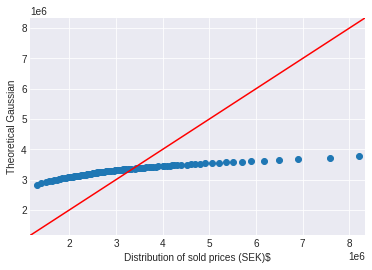

In [19]:
q1 = stats.norm.ppf(p, loc=X_sold_price.mean(), scale=200000)
qqplot_x = qqplot_2samples(quantiles(X_sold_price), q1, line='45', 
        xlabel='Distribution of sold prices (SEK)$', ylabel='Theoretical Gaussian')

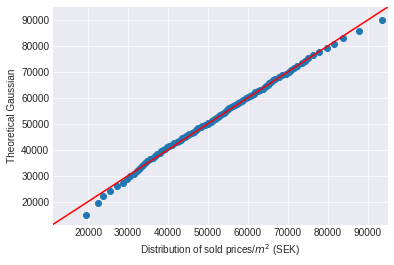

In [20]:
# Theoretical distribution

def gaussian(X):
    """Returns a theoretical Gaussian distribution with the sample median of X for comparison
    """
    p = np.linspace(1, 99, num=100)*0.01
    return stats.norm.ppf(p, loc=X.mean(), scale=X.std())
q1 = gaussian(X_sold_price_sqm) 
qqplot_x = qqplot_2samples(quantiles(X_sold_price_sqm), q1, line='45',
                          xlabel='Distribution of sold prices/$m^2$ (SEK)', ylabel='Theoretical Gaussian')


The QQ plots were estimated assuming the sample mean represented the true mean, but with an arbitrary standard deviation.  It can be seen that both distributions follow a Gaussian distribution to a greater or lesser extent, but the exact parameters are unknown.  

The tails of the distribution of price per square metre do not match the theoretical distribution as well as the straight sold price.  As such, the preferable output variable of an output variable.  The standard deviation of the distribution was calculated using MLE, with the sample mean as the mean parameter for the distribution which had already been used (see above).

The Gaussian distribution is written as: $\frac{1} {\sqrt{2\pi \sigma^2}} e ^ {-\frac{1}{2} (\frac{x - \mu}{\sigma})^2  }$ where $\mu$ is the mean and $\sigma$ is the standard deviation.

Since it was established that the distribution is Gaussian, the maximum likelihood variables are the sample mean and standard distribution.  This was calculated using the scipy library (using the pre-known mean), and then confirmed against the sample mean and standard distribution.  The same procedure was carried out for the scaled prices.

In [21]:
from scipy.stats import norm
norm.fit(X_sold_price, floc=X_sold_price.mean())

(3298064.8723958335, 1486485.1577522147)

In [22]:
X_sold_price.mean(), X_sold_price.std()

(3298064.8723958335, 1486872.414540798)

In [23]:
data_avgift_sqm.mean(), data_avgift_sqm.std()

(60.53963294983832, 10.908799287756754)

### Apartment floor vs sold price

A potentially interesting feature is the extent to which the floor of an apartment affects the price.  Someone who lives on the ground floor has no stairs to climb, making it easier to bring shopping home, or get young children or older relatives into or out of the apartment, therefore making it a positive feature.  On the other hand, an apartment closer to the ground has a less good view, is colder, and gets more sounds from outside (e.g people talking, snow trucks, recycling vans etc.)  This could go down to personal preference, but the lack of information could lead to someone paying extra for a feature which should in fact drive the price down according to the property market in the city.

Therefore, this section, we will consider the following hypotheses:

* **Hypothesis 1**: An apartment on the ground floor will have a lower price to an equivalent apartment on a higher floor.
* **Hypothesis 1A**: An apartment on the ground floor in a building without a lift will have a lower price than an equivalent apartment on a higher floor.


To avoid performing a hypothesis test on the same data twice, the data were separated into two equally sized samples and each hypothesis test run on those in order to run hypothesis tests concerning the lifts and ground floor.  Here we will split the data, check that the distributions match, and make sure each group is large enough to be statistically valid.  

The hypothesis test concerning the rooms and living space is run on a separate subset of the data, and is not included in this consideration.

In [24]:
X_floors_data, X_floors_lift_data, Y_floors_data, Y_floors_lift_data = \
    train_test_split(data, data['sold_price'], test_size=0.5, random_state=42)


### Ensure datasets are big enough

It is a limitation of the data that there is often imprecision about what exactly constitutes the "ground" floor.  It may start at 0 or 1, or be slightly above the building's main entrance but still the lowest floor.  As such, we are considering that any apartment with floor number 0 or 1 is a ground floor apartment.

Further, we make the assumption that if it is unknown whether an apartment has a lift, it will be considered to not have a lift as this is an additional feature which would be sure to have been included in the advertisement.

In [25]:
# Make sure that there are enough ground floor apartments in apartments with/without a lift
X_floors_lift_data.loc[X_floors_lift_data['has_lift'] == 1].loc[X_floors_lift_data['floor'] < 2].count()

sold_price          71
rooms               71
living_space        71
has_balcony         71
floor               71
avgift              71
driftskostnad       71
built               71
has_lift            71
avgift_sqm          71
sold_price_sqm      71
cost_per_month      71
cost_per_sqm        71
scaled_price        71
scaled_price_sqm    71
dtype: int64

In [26]:
X_floors_lift_data.loc[X_floors_lift_data['has_lift'] == 0].loc[X_floors_lift_data['floor'] < 2].count()

sold_price          150
rooms               150
living_space        150
has_balcony         150
floor               150
avgift              150
driftskostnad       150
built               150
has_lift            150
avgift_sqm          150
sold_price_sqm      150
cost_per_month      150
cost_per_sqm        150
scaled_price        150
scaled_price_sqm    150
dtype: int64

### Testing hypothesis 1

Hypothesis 1 was defined as: *An apartment on the ground floor will have a lower price to an equivalent apartment on a higher floor.*

We define the null hypothesis $H_0$ and alternative hypothesis $H_A$ as follows:

Let $G$ be the distribution of all ground floor apartments, and let $H$ be the distribution of all apartments not on the ground floor

$H_0: \mu G - \mu H = 0$

$H_A: \mu G < \mu H$

In [27]:
G = X_floors_data.loc[X_floors_data['floor'] < 2]
H = X_floors_data.loc[X_floors_data['floor'] >= 2]
G_price = G['sold_price']
H_price = H['sold_price']
# g_dist = qqplot_2samples(quantiles(G_price), gaussian(G_price), line='45')
# h_dist = qqplot_2samples(quantiles(H_price), gaussian(H_price), line='45')
# plt.show(g_dist, h_dist)

mu_g = G_price.mean()
mu_h = H_price.mean()
mu_g, mu_h

res = stats.ttest_ind(G_price, H_price, equal_var=False, random_state=42)
res

Ttest_indResult(statistic=-4.296635035600985, pvalue=2.1060094774727656e-05)

In [28]:
mu_g = G_price.mean()
mu_h = H_price.mean()
mu_g, mu_h

res = stats.ttest_ind(G_price, H_price, equal_var=False, random_state=42)
res

Ttest_indResult(statistic=-4.296635035600985, pvalue=2.1060094774727656e-05)

In [29]:
p = res.pvalue
s = f"Given that $p < .05$ we can conclude that it is possible to **reject** the null hypothesis "\
f"in favour of the alternative hypothesis, that the floor of an apartment is more expensive with a "\
f"significance level of p = {p:.20f}"
Markdown(s)

Given that $p < .05$ we can conclude that it is possible to **reject** the null hypothesis in favour of the alternative hypothesis, that the floor of an apartment is more expensive with a significance level of p = 0.00002106009477472766

In [30]:
def t(X, Y, c=0):
    s_x2 = X.std() ** 2
    s_y2 = Y.std() ** 2    
    n_x = len(X)
    n_y = len(Y)
    
    numerator = X.mean() - Y.mean() - c
    denominator = math.sqrt(s_x2 / n_x + s_y2 /n_y)
    
    return numerator / denominator

def df(X, Y):
    s_x2 = X.std() ** 2
    s_y2 = Y.std() ** 2
    n_x = len(X)
    n_y = len(Y)
    
    numerator = math.pow(s_x2 / n_x + s_y2 / n_y, 2)
    denominator = ((s_x2 / n_x)  ** 2 / (n_x - 1) + (s_y2 / n_y)  ** 2 / (n_y - 1))
    return numerator / denominator

print('t', t(G_price, H_price))
print('df', df(G_price, H_price))

t -4.296635035600985
df 473.12995661281275


### Testing hypothesis 1A

Since we conclusively rejected the null hypothesis for hypothesis 1, we tested hypothesis 1A as a follow-up:

Hypothesis 1 was defined as: *An apartment on the ground floor in a building without a lift will have a lower price than an equivalent apartment on a higher floor.*


We define the null hypothesis $H_0$ and alternative hypothesis $H_A$ as follows:

Let $G$ be the distribution of all ground floor apartments in buildings without a lift, and let $H$ be the distribution of all apartments not on the ground floor:

$H_0: \mu G - \mu H = 0$

$H_A: \mu G < \mu H$

Let the significance level be $\alpha = 0.05$.

In [31]:
# Ensure that there are enough data and that they both follow a normal distribution
G = X_floors_lift_data.loc[X_floors_lift_data['has_lift'] == 0].loc[X_floors_lift_data['floor'] < 2]
H = X_floors_lift_data.loc[X_floors_lift_data['has_lift'] == 0].loc[X_floors_lift_data['floor'] >= 2]

G_price = G['sold_price']
H_price = H['sold_price']
# g_dist = qqplot_2samples(quantiles(G['sold_price']), gaussian(G_price), line='45')
# h_dist = qqplot_2samples(quantiles(G['sold_price']), gaussian(H_price), line='45')
# plt.show(g_dist, h_dist)

res = stats.ttest_ind(G_price, H_price, equal_var=False)
res

Ttest_indResult(statistic=-1.8663374291781474, pvalue=0.06282715097387886)

In [32]:
res = stats.ttest_ind(G_price, H_price, equal_var=False)
res

Ttest_indResult(statistic=-1.8663374291781474, pvalue=0.06282715097387886)

In [33]:
G_price.mean(), H_price.mean()

(2764500.0, 2971183.8006230528)

In [34]:
s = f"The t-test returned a result of $p = {res.pvalue}$, which means it is not possible to reject "\
"$H_0$ in favour of $H_A$."
Markdown(s)

The t-test returned a result of $p = 0.06282715097387886$, which means it is not possible to reject $H_0$ in favour of $H_A$.

### Amount of rooms and living space

Another intuition is that having more rooms for the apartment space is desirable in an apartment, and consequently apartments which are otherwise equivalent will be more expensive if they have more rooms.  This is an additional piece of information necessary for someone to have when purchasing a new apartment for the first time.  Therefore, hypothesis 2 will be:

* **Hypothesis 2**: An apartment with more rooms will be more expensive than an otherwise equivalent apartment.

Note that for this test the `scaled_price_sqm` is considered as a response variable rather than `sold_price_sqm`.  The reason for this was that the nature of different voting districts could influence the type of apartments which are built, thereby causing a different effect on the price.  For example, apartments in central Gothenburg are more expensive than Bifrost in Mölndal, but it is plausible that city centre apartments would be smaller due to the relative population density.  This was not been confirmed, but operated as a working assumption.


The null hypothesis $H_0$ and alternative hypothesis $H_A$ were defined as follows:

Let $G$ be the distribution of all apartments with 2 rooms, and let $H$ be the distribution of all apartments with 3 rooms.

$H_0: \mu G - \mu H = 0$

$H_A: \mu G < \mu H$

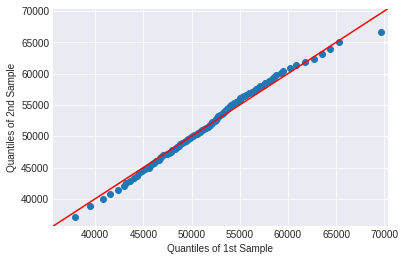

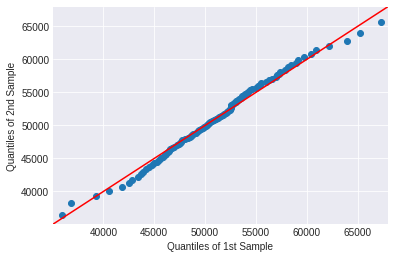

In [35]:
# data['scaled_price_sqm'] = data['scaled_price']
X_2_room_data = data.loc[data['rooms'] == 2]
X_3_room_data = data.loc[data['rooms'] == 3]

G_price = X_2_room_data['scaled_price_sqm']
H_price = X_3_room_data['scaled_price_sqm']
g_dist = qqplot_2samples(quantiles(G_price), gaussian(G_price) , line='45')
h_dist = qqplot_2samples(quantiles(H_price), gaussian(H_price) , line='45')
plt.show(g_dist, h_dist)


In [36]:
G_price.mean(), H_price.mean()

(51889.22383841071, 51049.30403736234)

In [37]:
res = stats.ttest_ind(G_price, H_price, equal_var=False)
res

Ttest_indResult(statistic=2.478030513145915, pvalue=0.013336569568987001)

In this case, it was possible to reject the null hypothesis, but not in favour of $H_A$ because $\mu G > \mu H$.  This was a really surprising result, which cannot immediately be explained.

## Split the data and test the distributions

For the final consideration of the distributions, the data were split to be 80\% train and 20\% train using the standard sklearn train_test_split function.  To determine similarity between the two distributions quantiles based on the following three columns were used:

* Rooms - As per conventions in Sweden, this is the amount of rooms in the apartment, excluding the kitchen and bathroom.
* Living space - The size of the apartment in m$^2$
* Avgift/m$^2$ - The monthly fee charged by the BRF to the owner every month per m$^2$

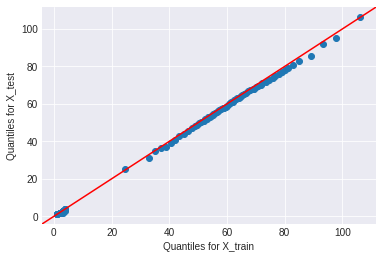

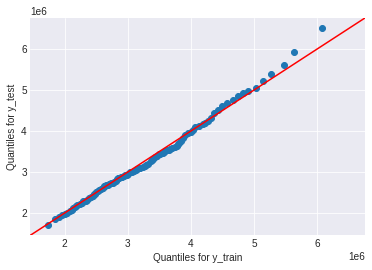

In [38]:
Y_full = data['scaled_price']

X_train, X_test, Y_train, Y_test = train_test_split(data, Y_full, test_size=0.2, random_state=42)
X_train = X_train.drop(columns=['scaled_price', 'scaled_price_sqm', 'sold_price'])
X_test = X_test.drop(columns=['scaled_price', 'scaled_price_sqm', 'sold_price'])

def comparison_quantiles(x1, x2):
    x1_out = []
    x2_out = []
    for p in np.linspace(1, 99, num=100)*0.01:
        x1_out.append(np.quantile(x1, p))
        x2_out.append(np.quantile(x2, p))
    return np.array(x1_out), np.array(x2_out)
columns = ['living_space', 'rooms', 'avgift_sqm']
X_train_columns = X_train[columns]
X_test_columns = X_test[columns]

X_train_quantiles, X_test_quantiles = comparison_quantiles(X_train_columns, X_test_columns)

qqplot_x = qqplot_2samples(X_train_quantiles, X_test_quantiles, line='45', 
                       xlabel='Quantiles for X_train', ylabel='Quantiles for X_test')

y_train_quantiles, y_test_quantiles = comparison_quantiles(Y_train, Y_test)
qqplot_y = qqplot_2samples(y_train_quantiles, y_test_quantiles, line='45', 
                       xlabel='Quantiles for y_train', ylabel='Quantiles for y_test')

Comparing both the similarity between samples of both the predictor variables and response variables, the split of the data was clearly adequate.

## Predictive analysis (7pts)
* Apply two predictive machine learning models to solve your problem. You can use anything from [here](https://scikit-learn.org/stable/) or other libraries
* For each model, state the following:
    * What is the name of the model?
    * What is the mathematical expression of the model?
    * What are the hyperparameters?
    * What are the parameters? 
    * A short description of how to estimate the parameters? 
* Evaluate their performance. Which one do you prefer and why?
* Run the algorithm you prefer on the test data set and draw a conclusion.


The target output is a prediction of the sold price of a given apartment, scaled based on the voting district it is located in.  As the price is a real number rather than a categorical variable, this requires that we use regression models.  For this project we will use linear regression and regression decision trees.

## Linear regression model

A linear regression model in the general sense may be defined as

$y = \beta_0 + \beta_1X_1 + ... + \beta_pX_p$ where $\beta_1$ is the intercept, $X$ is a feature vector, and $\beta_1 ... \beta_p$ are a series of weights associated with each feature in the model.

For ordinary least squares regression, as used in this case, there are no hyperparameters.

To begin, we naively use all features available from the dataset.  Afterwards, we refine the model in order to obtain the optimal outcome.

In the sklearn linear regression model, the `model.score` method returns the $R^2$ score. $R^2$ is defined as
$1 - \frac{u}{v}$, where $u$ is the sum of squared error of the response variable, and $v$ is the overall error in the model.  $1$ is the best score, and $-1$  is the worst.  A score of less than $0$ means the model is worse than a mere constant line which does not account for any variables.  

Although the $R^2$ scores is useful, the measure chosen instead was mean absolute error.  This is because it is possible to return a distribution using `sklearn.metrics` which can be used in hypothesis tests.  This was chosen rather than mean squared error (MSE) or root mean squared error (RMSE) because there is no need to punish bigger deviations.  Given that even a 1% error of the mean scaled price (3.3 million SEK) represents 33.000 SEK which is a significant sum of money.

### Feature selection

Regression is a predictive model which can perform worse with the addition of extra input variables, so we need to be careful in selecting which features we will use.  For convenience, a copy of the first records in the dataset is reproduced:

In [39]:
X_train.head()

,rooms,living_space,has_balcony,floor,avgift,driftskostnad,built,has_lift,avgift_sqm,sold_price_sqm,cost_per_month,cost_per_sqm
1179,2.0,61.0,1.0,2.0,3632.0,6300.0,1947,0,59.540984,40163.934426,4157.00,68.147541
945,4.0,205.0,1.0,5.0,8203.0,5880.0,1888,1,40.014634,65121.951220,8693.00,42.404878
213,4.0,83.0,1.0,2.0,4182.0,5421.0,2012,1,50.385542,50602.409639,4633.75,55.828313
1995,2.0,42.0,False,1.0,2627.0,1800.0,1933,0,62.547619,63095.238095,2777.00,66.119048
1716,3.0,73.0,1.0,1.0,4529.0,6600.0,1965,0,62.041096,41095.890411,5079.00,69.575342


Out of these data, some will clearly not be included as features.  The id and address, whilst useful for reference, will have no impact on the result and so will not be included.  The `valdistrikt` (voting district) will also not be used, since it has already been used in the calculation of the scaled price, and there are too many unique values for it to be statistically valid.



### Dependence between predictors and response variables

In the section on descriptive analysis, a heatmap was analysed indicating that there were no strong predictors between the predictor variables and the response variable.  This is quantified in the chart below, which uses the mutual information metric to determine the relevance.

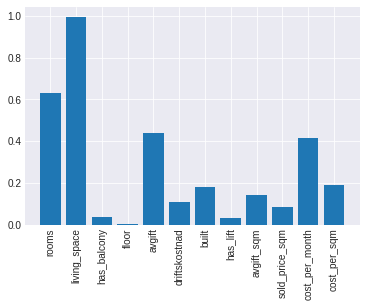

In [40]:
discrete_features = [0, 2, 3, 6, 7]
mir = mutual_info_regression(X_train, Y_train, discrete_features=discrete_features)
fig = plt.bar([c for c in X_train.columns], mir)
plt.xticks(rotation=90)
plt.show()

### Parameter tuning

In the following section, we iteratively improve the model using recursive feature elimination with repeated stratified k-fold split on X_test.  As it has already been determined that some of the features suffer from collinearity, we will seek to optimise for different sets of starting features.

In [41]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

In [42]:
# Model with a different amount of parameters
def get_models(X, estimator=LinearRegression):
    models = []
    for i in range(1, len(X.columns)):
        rfe = RFE(estimator=estimator(), n_features_to_select=i)
        model = estimator()
        models.append(Pipeline(steps=[('s', rfe), ('m', model)]))
    return models

def evaluate(X, y, features, models):
    scores = []
    for i, m in enumerate(models):
        X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X[features], y, random_state=i)
        m.fit(X_i_train, y_i_train)
        y_i_pred = m.predict(X_i_test)
        score = mean_absolute_error(y_i_test, y_i_pred)
        scores.append(score)
    return models, scores

def test(X_train, y_train, X_test, y_test, features, model_class=LinearRegression):
    """Tests the best model on the test data
    
    :return: A tuple of MAE score (low is good), and an array of the AE for each item
    """
    model = model_class()
    model.fit(X_train[features], y_train)
    Y_pred = model.predict(X_test[features])
       
    
    return mean_absolute_error(Y_test, Y_pred), np.abs(Y_test - Y_pred)
    

In [43]:
def best_rfe(models, scores):
    best = scores.index(min(scores))
    return models[best].steps[0][1], min(scores)

In [44]:
features = ['rooms', 'living_space', 'has_balcony', 'floor', 'avgift', 'driftskostnad','has_lift', 'avgift_sqm', 
            'has_balcony', 'built']
models_0 = get_models(X_train[features])
models_0, scores_0 = evaluate(X_train, Y_train, features, models_0)    

best_0, _ = best_rfe(models_0, scores_0)
# vars(models_0[1])['steps'][0][1].support_
best_0_test = test(X_train, Y_train, X_test, Y_test, best_0.feature_names_in_[best_0.get_support()])
best_0.feature_names_in_[best_0.support_]

array(['rooms', 'living_space', 'has_balcony', 'floor', 'has_lift',
       'avgift_sqm', 'has_balcony', 'built'], dtype=object)

In [45]:
features = ['rooms', 'living_space', 'has_balcony', 'floor', 'has_lift', 'cost_per_month', 'cost_per_sqm', 
            'has_balcony', 'built']
models_1 = get_models(X_train[features])
models_1, scores_1 = evaluate(X_train, Y_train, features, models_1)    
best_1, _ = best_rfe(models_1, scores_1)
best_1_test = test(X_train, Y_train, X_test, Y_test, best_1.feature_names_in_[best_1.get_support()])
best_1.feature_names_in_[best_1.support_]

array(['rooms', 'living_space', 'has_balcony', 'floor', 'has_lift',
       'cost_per_sqm', 'has_balcony', 'built'], dtype=object)

In [46]:
features = ['rooms', 'has_balcony', 'floor', 'has_lift', 'cost_per_month', 'cost_per_sqm', 
            'has_balcony', 'built']
models_2 = get_models(X_train[features])
models_2, scores_2 = evaluate(X_train, Y_train, features, models_2)    
best_2, _ = best_rfe(models_2, scores_2)

best_2_test = test(X_train, Y_train, X_test, Y_test, best_2.feature_names_in_[best_2.get_support()])
best_2.feature_names_in_[best_2.support_]

array(['rooms', 'has_balcony', 'floor', 'has_lift', 'cost_per_month',
       'cost_per_sqm', 'has_balcony'], dtype=object)

In [47]:
features = ['living_space', 'has_balcony', 'floor', 'has_lift', 'cost_per_month', 'cost_per_sqm', 
            'has_balcony', 'built']

models_3 = get_models(X_train[features])
models_3, scores_3 = evaluate(X_train, Y_train, features, models_3)    
best_3, _ = best_rfe(models_3, scores_3)
best_3_test = test(X_train, Y_train, X_test, Y_test, best_3.feature_names_in_[best_3.get_support()])
best_3.feature_names_in_[best_3.support_]

array(['living_space', 'has_lift', 'has_balcony'], dtype=object)

In [48]:
linear_regression_results = [best_0_test[0], best_1_test[0], best_2_test[0], best_3_test[0]]
linear_regression_results

[303602.34277652024, 303053.4050044731, 353281.88034380024, 307220.1440512291]

The results show that there is very little difference between the tuned parameters aside from the third estimation which excluded the living space as it predicts the amount of rooms.  Since this feature is the clear best, this is an unsurprising result.  As the second and fourth iteration are largely the same, and the fourth has fewer parameters, a hypothesis test was performed to determine whether there was any significant difference.

Let $G$ be the distribution of absolute errors of the model $M_0$ which ran with 8 features: `'rooms', 'living_space', 'has_balcony', 'floor', 'has_lift', 'avgift_sqm', 'has_balcony', 'built'` represented by the variable `best_0`

Let $H$ be the distribution of absolute errors of the model $M_1$ which ran with 3 features `'living_space', 'has_lift', 'has_balcony'` represented by the variable `best_3`.

If $M_0$ is superior with significance $p < .05$, this model will be selected, otherwise $M_1$ will be selected

$H_0: \mu G - \mu H = 0$ 

$H_0: \mu G - \mu H < 0$ 

In [49]:
stats.ttest_rel(best_0_test[1], best_3_test[1])

Ttest_relResult(statistic=-0.7476524216845079, pvalue=0.45512862691030886)

Since it is not possible to reject the null hypothesis, $M_1$ was selected as the optimal for linear regression on the dataset.

The model $M_1$ predicts $\hat y$ with the following values:

In [50]:
model = best_3.estimator.fit(X_train[best_3.feature_names_in_[best_3.get_support()]], Y_train)
best_3.feature_names_in_[best_3.get_support()], model.coef_, 

s = f"Let Let $X_1$ be living space in sqm, $X_2$ be has lift and $X_3$ be has balcony. The linear " \
"regression model is defined as:\n\n" \
f"$y = {model.intercept_} + {model.coef_[0]}X_1 + {model.coef_[1]}X_2 + {model.coef_[2]}X_3$"
Markdown(s)

Let Let $X_1$ be living space in sqm, $X_2$ be has lift and $X_3$ be has balcony. The linear regression model is defined as:

$y = 380971.86265609134 + 44205.97852594123X_1 + 73635.68631855433X_2 + 67879.74314197013X_3$

## Decision tree regression

The alternative model to test on the data is to use a regression decision forest.  For the feature selection in the decision forest the inbuilt parameter estimation CART algorithm scoring using squared error criterion.  However, unlike linear regression there are hyperparameters to the model which need to be considered.  To discover the optimal hyperparameters, an exhaustive grid search was used on the decision tree hyperparameters, which can be seen in the function below.

The forest used the default sklearn of 100 trees.  In future work, this will be analysed as well.

In [51]:
def tune_hyperparameters(X, y, features):
    param_grid = {
        'max_depth': [4, 8, 16, 32, None],
        'min_samples_split': [2, 4, 8, 16],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': [i for i in range(2, len(features) + 1)]
    }
    base_estimator = RandomForestRegressor()

    clf = GridSearchCV(estimator=base_estimator, param_grid=param_grid, n_jobs=-1)
    clf.fit(X[features], y)
    return clf

In [52]:
features = ['rooms', 'living_space', 'has_balcony', 'floor', 'avgift', 'driftskostnad','has_lift', 'avgift_sqm', 
            'has_balcony', 'built']

best_model = tune_hyperparameters(X_train, Y_train, features)

In [53]:
y_pred = best_model.best_estimator_.predict(X_test[features])
decision_forest_error = mean_absolute_error(Y_test, y_pred)
decision_forest_ae_array = np.abs(Y_test - y_pred)
# decision_forest_ae_array


## Comparison of linear regression and decision tree regression

For this section, a paired t-test was performed on the squared error of each prediction by both models.  Recall that this means that the lower value is the better performing model.

The null hypothesis stated:

Let $L$ be the distribution of the absolute errors in the linear regression model, and let $D$ be the distribution of the absolute errors in the decision forest model.

$H_0: \mu L = \mu D$

The alternative hypothesis stated that:

$H_A: \mu D < \mu L$

In [54]:
s = f"The unweighted mean of the absolute errors was: {best_0_test[0]} "\
f"for the linear regression model and {decision_forest_error} for the decision forest"
Markdown(s)

The unweighted mean of the absolute errors was: 303602.34277652024 for the linear regression model and 290312.84334175196 for the decision forest

In [55]:
stats.ttest_rel(best_0_test[1], decision_forest_ae_array)

Ttest_relResult(statistic=1.9713033171745502, pvalue=0.04940865400271425)

The result failed to reject the null hypothesis, and had $p = 0.12$, so there is no significant difference between the two models.  Although the decision forest performed slightly better, the grid search in hyperparameter estimation made the run-time siginificantly longer than for linear regression.  Whilst this can be optimised, and is only a one-off operation, this suggests that using linear regression would be slightly preferable.

## Conclusion (1 pts)

* State again your problem and the motivation. 
* Draw a conclusion from the project. 
* If you keep working on this project, what would be the next step?   


Recall from section 1 that the project definition was:

*This project uses a dataset of historical apartment purchases from hemnet.se to assist first time buyers with limited information predict the true value of a property in Gothenburg and Mölndal municipalities based on different characteristics of the property*

As well as the descriptive analysis, there were two substantial parts to the research.  The first was the investigation as to the effect of an apartment's floor on the price, and the second was the predictive analysis for predicting an apartment based on its location and a variety of other factor.

## Discussion

The hypothesis tests came with the caveat that the assumption of a Gaussian distribution is violated, and as such the results should be treated with caution.  It confirmed what one might think intuitively, that a ground floor apartment is not as good as an apartment on a higher floor where there is a lift, but where there is not known to be a lift the price difference is not significant.  The other hypothesis test produced an unexpected result, that the apartments with two rooms are significantly more expensive (relatively) than the ones with three apartments despite being scaled.  There is no explanation, so the assumptions will need to be fundamentally reconsidered for this test.

In retrospect the models were never likely to provide the accuracy or predictive power necessary, and despite performing fairly well with very few features are not accurate enough for any production use.  That the decision forest performed comparably to the linear regression model was surprising, but possibly it illustrates the extent to which the living space feature (along with the voting district) dominated the estimation.

## Future work

There are several things which could be done to potentially improve the performance of the models in the future.  

Firstly, some of the variables could have been used better in the model. For example, it may have been better to have modified the build year of the apartments into categories so that there would have been a greater amount in each category and so could have helped to improve prediction in that way.  This may already have been done in the decision tree model.

Secondly, the effects of collinearity on both regression models were not explored fully.  Despite the relations between the predictor variables, it did not appear to make much of a difference (even on the test data) which were included.  This should be more thoroughly investigated to discover the effect it had on performance.

Gathering more data is also (always!) desirable, and would arguably have made some of the analysis more statistically valid.  This may require going further back in time, which would require additional effort to standardise prices over time which may complicate the analysis.  Also, although most of the distributions which were analysed approximated Gaussian distributions, they were not perfect, so conducting non-parametric tests may also yield better results.